<a href="https://colab.research.google.com/github/lourencocavalcante/Neurocomputacao/blob/main/CAP351_Projeto_01_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" width = 500 align="left">](https://www.gov.br/inpe/pt-br)

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 300 align="right">](http://www.inpe.br/posgraduacao/cap/)

# **CAP-351 Neurocomputação**

**Professor:**
*Dr. Marcos Goncalves Quiles*

**Aluno:**
*Lourenço José Cavalcante Neto*

---

**PROPOSTA DE PROJETO 1: Experimentos com a rede Multi-layer Perceptron (MLP)**

**Descrição do projeto:**

1. Selecionar dois datasets (não triviais): Um dataset para classificação; Um dataset para regressão; Separar em treino/validação/teste.

2. Treinar modelos MLP para os dois problemas (**classificação** e **regressão**)

3. Considerar:
  * Diferentes topologias (>=5 topologias, variar número de
camadas)
  * Usar o algoritmo original SGD (não usar algoritmos otimizados,
e.g. ADAM)
  * Avaliar o impacto do uso do Momentum
  * Avaliar o impacto do uso da regularização (i.e. L2)

4. Ilustrar graficamente a evolução do treinamento (treino/validação).

5. Confeccionar um relatório (reprodutível) contendo os
experimentos e resultados

O presente material pode ser acessado no **github**: 

# Bibliotecas/Pacotes

In [1]:
import pandas as pd

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
import datetime

from google.colab import drive
drive.mount('/content/drive')

print(tf.__version__)

Mounted at /content/drive
2.8.2


# Dataset
 
Os Dados são de um equipamento chamado **Disdrômetro RD80** (também chamado de **Joss**). Instalado próximo à torre **ATTO**, em um sítio chamado Campina, na região amazônica, o Disdrômetro RD80 mede a distribuição das gotas de chuva que chegam à superfície. No total, o Dataset possui 06 atributos, os são listados abaixo:

```
Datetime
Rain Intensity (mm/h)
radar reflectivity (1/mm6m3)
Liquid watercontent (g/m3)
Mean weight diameter(mm)
Time integration (s)
```

*Ob.: Conforme sugerido/autorizado pelo professor Marcos na aula do dia 11/07, o mesmo Dataset será utilizado para os problemas de Classificação e Regressão.*

**Importação, Formatação e Tratamento nos dados**

In [9]:
#Importando o Dataset e criando o Dataframe
df_rd80 = pd.read_csv("/content/drive/MyDrive/MestradoCAP/Lourenco/cap351/Datasets/df_final_rd80_joss.csv")
df_rd80 = pd.DataFrame(df_rd80)

#Aqui verificamos o tamanho e quantidade de atributos do Dataset
print('Tamanho do dataset: ',df_rd80.shape[0], ', quantidade de atributos: ', df_rd80.shape[1])

Tamanho do dataset:  315420 , quantidade de atributos:  6


In [10]:
#Carregando o Dataset e criando o Dataframe
df_rd80.head(n=4)

,Datetime,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),Liquid watercontent (g/m3),Mean weight diameter(mm),Time integration (s)
0,2020-03-17 13:52:00,0.0,0.0,0.0,0.0,60.0
1,2020-03-17 13:53:00,0.0,0.0,0.0,0.0,60.0
2,2020-03-17 13:54:00,0.0,0.0,0.0,0.0,60.0
3,2020-03-17 13:55:00,0.0,0.0,0.0,0.0,60.0


In [11]:
#Vamos assumir que os valores para Rain Intensity (mm/h) que forem menores que 0.1 sejam considerados como 0(zero)
df_rd80['Rain Intensity (mm/h)'][df_rd80['Rain Intensity (mm/h)'] < 0.1] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


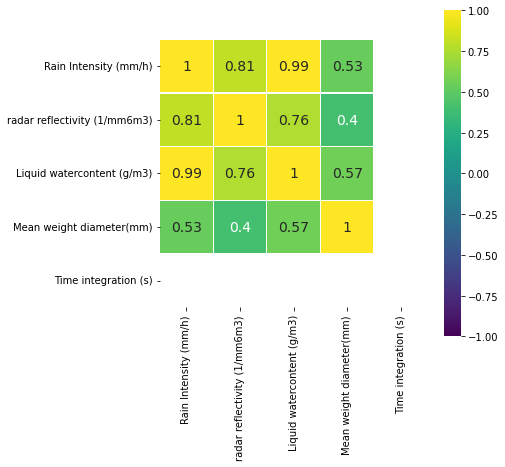

In [12]:
#Visualizando as correlações entre as variáveis
corr = df_rd80.corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)],cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 14}, square=True);

[]

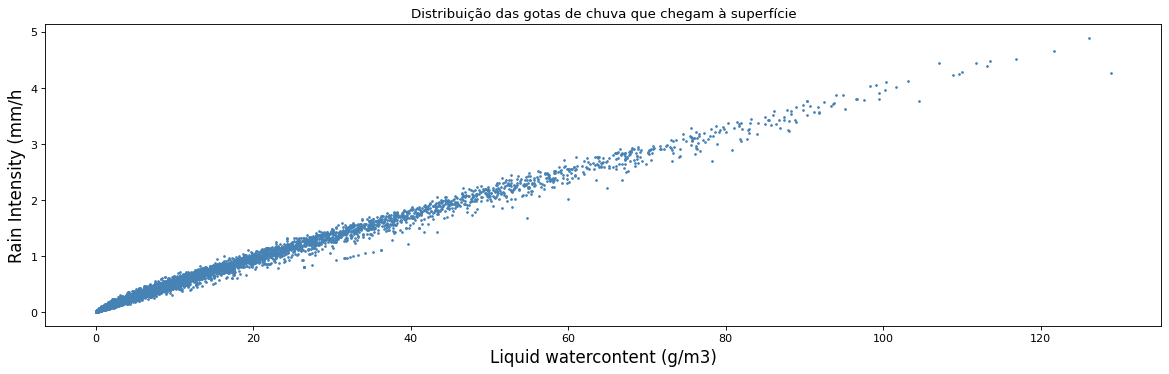

In [13]:
figure(figsize=(18,5),dpi=80)
plt.scatter(df_rd80['Rain Intensity (mm/h)'] ,df_rd80['Liquid watercontent (g/m3)'],s=2, color='#4682B4')
plt.xlabel(r'Liquid watercontent (g/m3)',size=15)
plt.ylabel(r'Rain Intensity (mm/h',size=15)
plt.title("Distribuição das gotas de chuva que chegam à superfície")
plt.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


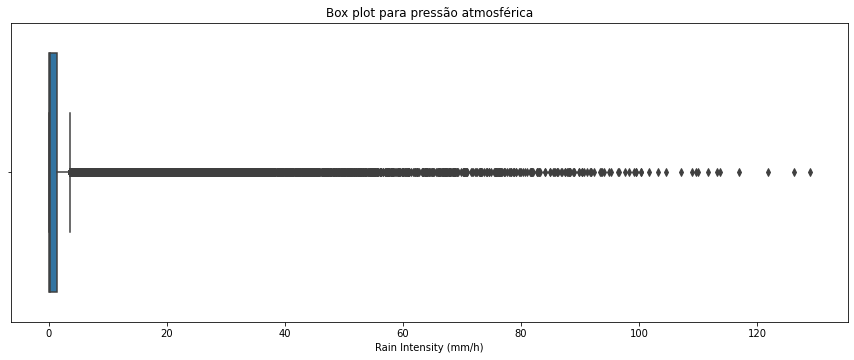

In [23]:
plt.figure(figsize=(15, 5.5))
g = sns.boxplot(df_rd80['Rain Intensity (mm/h)'].loc[df_rd80['Liquid watercontent (g/m3)'] > 0])
g.set_title('Box plot para pressão atmosférica')
plt.show()

Conforme orientações para o projeto, para realizar o treinamento e validação do aprendizado de uma rede **Multi-layer Perceptron (MLP)**, realizou-se a divisão do conjunto de dados em dois grupos: Treino (70%) e Teste (30%). A biblioteca scikit-learn nos auxilia nesta tarefa. 

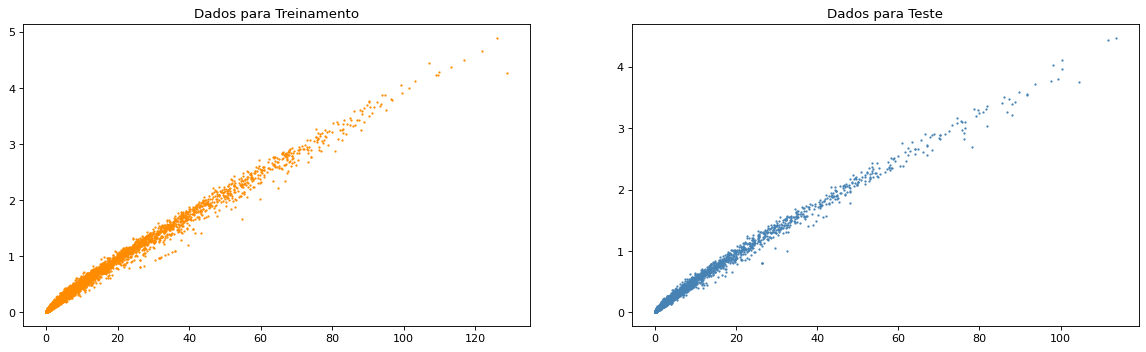

Tamanho do dataset para treinamento:  220794
Tamanho do dataset para validação:  94626


In [24]:
# Divisão do Dataset em treinamento e validação

x_train, x_test, y_train, y_test = train_test_split(df_rd80['Rain Intensity (mm/h)'] ,df_rd80['Liquid watercontent (g/m3)'], test_size=.30)

figure(figsize=(18,5),dpi=80)

plt.subplot(1,2,1)
plt.title('Dados para Treinamento')
plt.scatter(x_train, y_train, color='#FF8C00',s=1)

plt.subplot(1,2,2)
plt.title('Dados para Teste')
plt.scatter(x_test, y_test, color='#4682B4',s=1)
plt.show()


print('Tamanho do dataset para treinamento: ',len(x_train))
print('Tamanho do dataset para validação: ',len(x_test))

# Problema 1: Regressão

**Criação dos modelos**

Com o objetivo de construir uma rede capaz de encontrar uma lei de regressão para esses *problemas*, serão geradas 5 topologias de rede diferentes. O primeiro será o caso simples e clássico de um perceptron e o segundo aumentará o número de camadas e o número de neurônios.

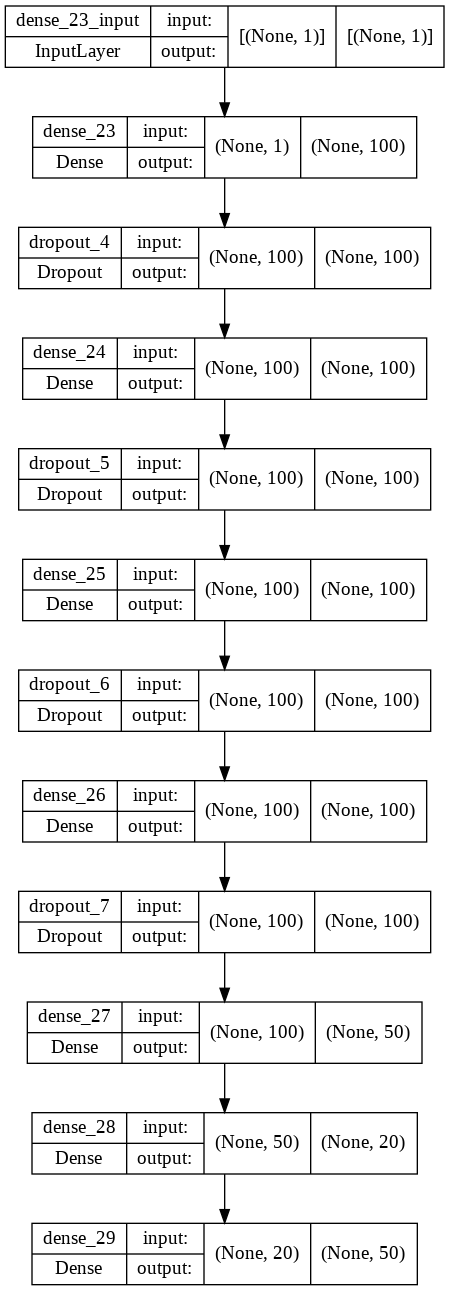

In [26]:
fl2 = 0.0
drop = 0.2

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0)
sgd_momentum_060 = SGD(learning_rate=0.01, decay=1e-6, momentum=0.20, nesterov=True) #0.60
adam = tf.keras.optimizers.Adam()

#modelo_a
modelo_a = keras.Sequential()
modelo_a.add(keras.layers.Dense(units=3, input_shape=[1], activation="tanh"))
modelo_a.add(keras.layers.Dense(units=1, activation="linear"))
#tf.keras.utils.plot_model(modelo_a, show_shapes=True)

#modelo_b
modelo_b = keras.Sequential()
modelo_b.add(keras.layers.Dense(units=5, input_shape=[1], activation="tanh"))
modelo_b.add(keras.layers.Dense(units=5, activation="tanh"))
modelo_b.add(keras.layers.Dense(units=1, activation="linear"))
#tf.keras.utils.plot_model(modelo_b, show_shapes=True)

#modelo_c
modelo_c = keras.Sequential()
modelo_c.add(keras.layers.Dense(units=5, input_shape=[1], activation="tanh"))
modelo_c.add(keras.layers.Dense(units=5, activation="tanh"))
modelo_c.add(keras.layers.Dense(units=1, activation="linear"))
#tf.keras.utils.plot_model(modelo_c, show_shapes=True)

#modelo_final
modelo_final = keras.Sequential()
modelo_final.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
modelo_final.add(Dropout(drop))
modelo_final.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
modelo_final.add(Dropout(drop))
modelo_final.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
modelo_final.add(Dropout(drop))
modelo_final.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
modelo_final.add(Dropout(drop))
modelo_final.add(keras.layers.Dense(units=50, kernel_regularizer=l2(fl2), activation="tanh"))
modelo_final.add(keras.layers.Dense(units=20, kernel_regularizer=l2(fl2), activation="sigmoid"))
modelo_final.add(keras.layers.Dense(units=50, activation="linear"))
tf.keras.utils.plot_model(modelo_final, show_shapes=True)

**Compilando os Modelos criados**

In [27]:
modelo_a.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])
modelo_b.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])
modelo_c.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])
modelo_final.compile(loss='mean_squared_error', optimizer=sgd_momentum_060, metrics=["mean_absolute_error"])

lista_modelos = [modelo_a, modelo_b, modelo_c, modelo_final]

**Agora vamos treinar os Modelos**

In [ ]:
epocas = 50 #Degine a quantidade de épocas para o treinamento

early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

history_modelo_a = modelo_a.fit(x_train, y_train, epochs=epocas, batch_size=10, validation_split=0.2, verbose=True) #callbacks=[early])
history_modelo_b = modelo_b.fit(x_train, y_train, epochs=epocas, batch_size=10, validation_split=0.2, verbose=True) #callbacks=[early])
history_modelo_c = modelo_c.fit(x_train, y_train, epochs=epocas, batch_size=10, validation_split=0.2, verbose=True) #callbacks=[early])
history_modelo_final = modelo_final.fit(x_train, y_train, epochs=epocas, batch_size=10, validation_split=0.2, verbose=True) #callbacks=[early])

lista_history_modelos = [history_modelo_a, history_modelo_b, history_modelo_c, history_modelo_final]

Epoch 1/50
17650/17664 [============================>.] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0102

In [ ]:
figure(figsize=(18,8),dpi=80)
plt.suptitle('EVOLUÇÃO DO TREINAMENTO DOS MODELOS', size=14)
for i, history_modelo in zip(range(0, len(lista_history_modelos)), lista_history_modelos):
    plt.subplot(2,2,i+1)
    plt.title('Modelo '+ str(i+1))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(history_modelo.history['loss'], label="MLP - Treino")
    plt.plot(history_modelo.history['val_loss'], label="MLP - Val")
    plt.legend()
plt.show()

**Avaliação (teste)**

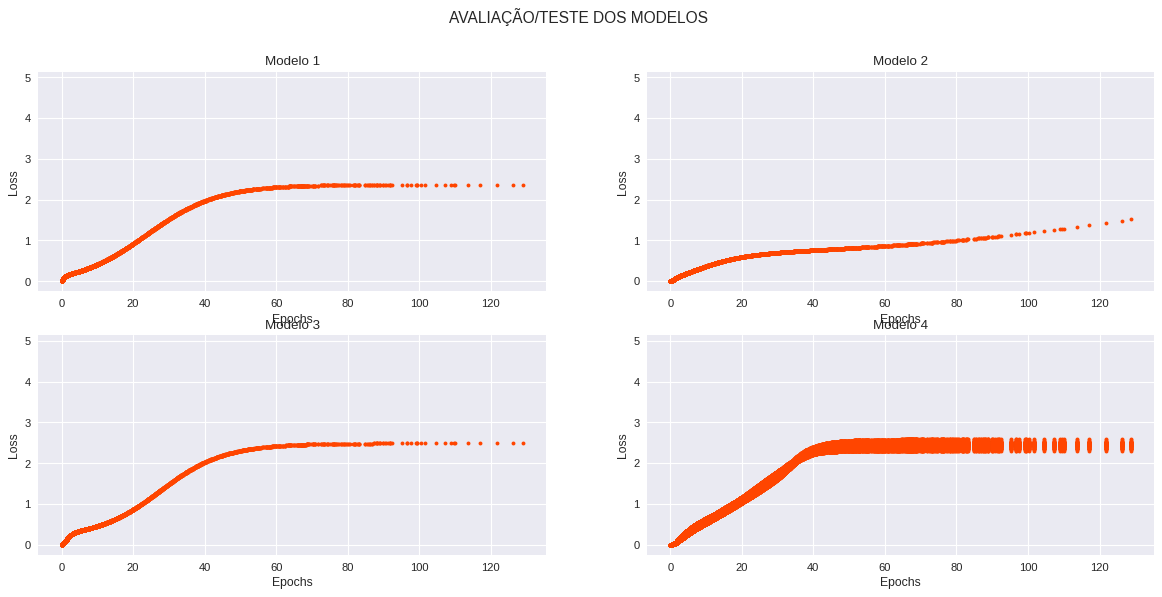

In [ ]:
figure(figsize=(18,8),dpi=80)
plt.suptitle('AVALIAÇÃO/TESTE DOS MODELOS', size=14)

for m, res_modelo in zip(range(0, len(lista_modelos)), lista_modelos):

  plt.subplot(2,2,m+1)
  y_rest = res_modelo.predict(x_train)
  plt.plot(x_train, y_train, '.', color='#4682B4')
  plt.plot(x_train, y_rest, '.',color='#FF4500')
  plt.title('Modelo '+ str(m+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()

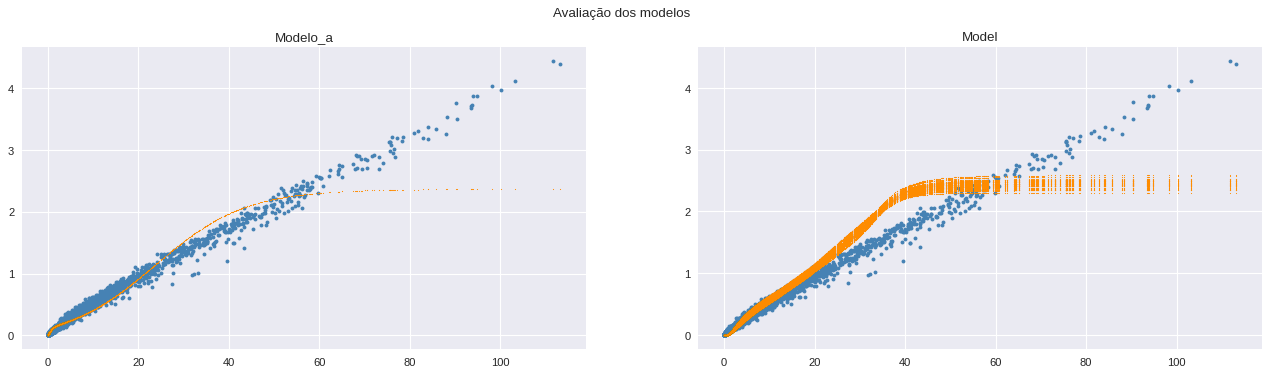

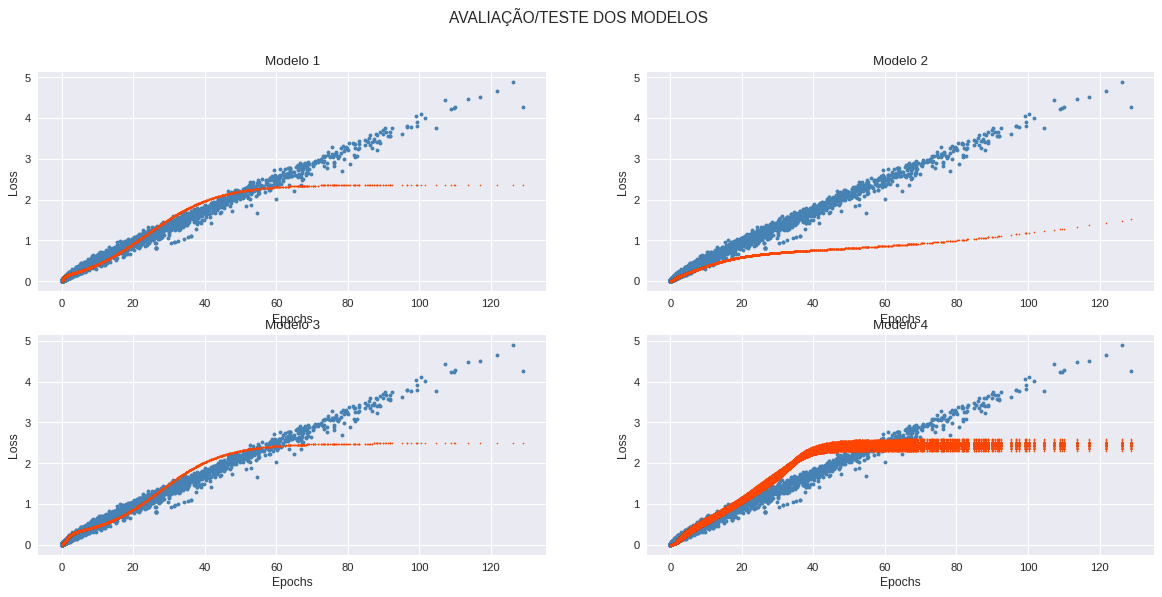

2958/2958 [==============================] - 5s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0082


In [ ]:
figure(figsize=(20,5),dpi=80)
plt.suptitle('Avaliação dos modelos')
plt.subplot(1,2,1)
y_res = modelo_a.predict(x_test)
plt.plot(x_test, y_test, '.', color='#4682B4')
plt.plot(x_test, y_res, '.', markersize=2, color='#FF8C00')
plt.title('Modelo_a')

plt.subplot(1,2,2)
y_res = modelo_final.predict(x_test)
plt.plot(x_test, y_test, '.', color='#4682B4')
plt.plot(x_test, y_res, '.', markersize=2, color='#FF8C00')
plt.title('Model')

plt.show()



figure(figsize=(18,8),dpi=80)
plt.suptitle('AVALIAÇÃO/TESTE DOS MODELOS', size=14)
for m, res_modelo in zip(range(0, len(lista_modelos)), lista_modelos):

  plt.subplot(2,2,m+1)
  y_rest = res_modelo.predict(x_train)
  plt.plot(x_train, y_train, '.', color='#4682B4')
  plt.plot(x_train, y_rest, '.', markersize=3 ,color='#FF4500')
  plt.title('Modelo '+ str(m+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()



test_loss = modelo_a.evaluate(x_test, y_test)
test_loss = modelo_b.evaluate(x_test, y_test)
test_loss = modelo_c.evaluate(x_test, y_test)
test_loss = modelo_final.evaluate(x_test, y_test)

In [ ]:
score_modelo_a = modelo_a.evaluate(x_test, y_test, verbose=0)
print("Teste loss:", score_modelo_a[0])
print("Teste metric:", score_modelo_a[1])
print("\n\n")
score_modelo_b = modelo_b.evaluate(x_test, y_test, verbose=0)
print("Teste loss:", score_modelo_b[0])
print("Teste metric:", score_modelo_b[1])
print("\n\n")
score_modelo_c = modelo_c.evaluate(x_test, y_test, verbose=0)
print("Teste loss:", score_modelo_c[0])
print("Teste metric:", score_modelo_c[1])
print("\n\n")
score_model_final = modelo_final.evaluate(x_test, y_test, verbose=0)
print("Teste loss:", score_model_final[0])
print("Teste metric:", score_model_final[1])

Teste loss: 0.00035688866046257317
Teste metric: 0.0032094819471240044



Teste loss: 0.0008907499141059816
Teste metric: 0.00457207253202796



Teste loss: 0.0018526342464610934
Teste metric: 0.004280781839042902



Teste loss: 0.0005300493212416768
Teste metric: 0.004824765492230654


# Problema 2: Classificação